In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
keras.__version__

In [ ]:
# confirm Keras sees the GPU (for TensorFlow 1.X + Keras)
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0
print(backend.tensorflow_backend._get_available_gpus())

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
# stack overflow example taken from: https://stackoverflow.com/questions/37747021/create-numpy-array-of-images
X_data = []
y = []

files = glob.glob ("./cell_images/Parasitized/*.png")
for myFile in files:
    image = cv2.imread(myFile,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(128,128))
    X_data.append(image)
    y.append((int)(1))
files = glob.glob ("./cell_images/Uninfected/*.png")
for myFile in files:
    image = cv2.imread(myFile,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(128,128))
    X_data.append (image)
    y.append((int)(0))
npArr =np.array(X_data)
print('X_data shape:', np.array(X_data).shape)

In [ ]:
print(npArr[0].shape)
print(npArr[1].shape)
pixels = npArr
pixels.shape

In [ ]:
y = np.array(y)
h=128
w=128
print(y)

In [ ]:
from matplotlib import pyplot as plt

# a helper plotting function

# def plot_gallery(images, titles, h, w,n_row=3, n_col=6):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i])
#         plt.title(titles[i], size=12)
#         plt.xticks(())
#         plt.yticks(())
#     plt.show()
# plot_gallery(x_train, y_train, h, w) # defaults to showing a 3 by 6 subset of the faces
print(y[0])
plt.imshow(pixels[0])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import keras.utils
from keras import utils as np_utils
x_train,x_test,y_train,y_test = train_test_split(pixels, y, test_size = 1/5, random_state = 1)
NUM_CLASSES = 2
y_train_ohe = keras.utils.to_categorical(y_train, 2)
y_test_ohe = keras.utils.to_categorical(y_test, 2)
print(x_train[:4000].shape)
print(y_train_ohe[:4000].shape)
x_train = x_train/255.0 - 0.5
x_test = x_test/255.0 - 0.5

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=360, # used, Int. Degree range for random rotations.
    width_shift_range=0.05, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.05, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)
datagen.fit(x_train)

In [ ]:
tmps = datagen.flow(x_train, y_train, batch_size=5000)
for tmp in tmps:
    x_train = np.concatenate((x_train,tmp[0]))
    y_train = np.concatenate((y_train,tmp[1]))
    break
print(x_train.shape)

In [ ]:
x_train_flat = []
for val in x_train:
    x_train_flat.append(np.ravel(val))
x_train_flat = np.array(x_train_flat)

## Ensemble Style CNN

In [11]:
cnn2 = Sequential()
cnn2.add( Conv2D(filters=16, 
                kernel_size=(3,3), 
                input_shape = (128,128,3),
                padding='same', 
                activation='linear',data_format="channels_last") ) # more compact syntax

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',data_format="channels_last") ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_last") )
    

# add one layer on flattened output
cnn2.add(Dropout(0.25))
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(64, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn2.compile(loss='binary_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
cnn2.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
______________________________________________________________

Train on 27046 samples, validate on 5512 samples
Epoch 1/10
27046/27046 [==============================] - 45s 2ms/step - loss: 0.3212 - acc: 0.8786 - val_loss: 0.1894 - val_acc: 0.9481
Epoch 2/10
27046/27046 [==============================] - 37s 1ms/step - loss: 0.1757 - acc: 0.9481 - val_loss: 0.1761 - val_acc: 0.9485
Epoch 3/10
27046/27046 [==============================] - 37s 1ms/step - loss: 0.1634 - acc: 0.9499 - val_loss: 0.1622 - val_acc: 0.9523
Epoch 4/10
27046/27046 [==============================] - 37s 1ms/step - loss: 0.1644 - acc: 0.9514 - val_loss: 0.1814 - val_acc: 0.9459
Epoch 5/10
27046/27046 [==============================] - 37s 1ms/step - loss: 0.1570 - acc: 0.9535 - val_loss: 0.1480 - val_acc: 0.9499
Epoch 6/10
27046/27046 [==============================] - 37s 1ms/step - loss: 0.1629 - acc: 0.9553 - val_loss: 0.1491 - val_acc: 0.9523
Epoch 7/10
27046/27046 [==============================] - 37s 1ms/step - loss: 0.1477 - acc: 0.9545 - val_loss: 0.1504 - val_acc:

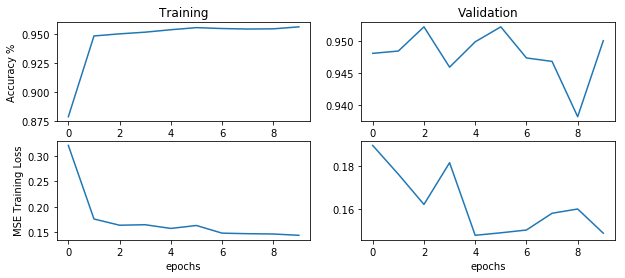

In [12]:
history = cnn2.fit(x_train, y_train, 
        batch_size=64, epochs=10, 
        shuffle=True, verbose=1,
        validation_data=(x_test,y_test))

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

In [ ]:
case1 = 0.0 # both models are correct
case2 = 0.0 # MLP correct, NN incorrect
case3 = 0.0 # NN correct, MPL incorrect
case4 = 0.0 # Both incorrect
yhat1 = np.argmax(model1.predict(x_test)
yhat2 = np.argmax(model2.predict(x_test)
for i, value in enumerate(y_test):
    if ((value == yhat1[i]) and (value == yhat2[i])):
        case1 += 1
    elif ((value == yhat1[i]) and (value != yhat2[i])):
        case2 += 1
    elif ((value != yhat1[i]) and (value == yhat2[i])):
        case3 += 1
    elif ((value != yhat1[i]) and (value != yhat2[i])):
        case4 += 1
    else:
        print(value, yhat2[i], yhat1[i])
case1 /= 6
case2 /= 6
case3 /= 6
case4 /= 6
print(np.round(case1), " | ", np.round(case2))
print(np.round(case3), " | ", np.round(case4))

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

## Alexnet style CNN

In [ ]:
%%time


cnn = Sequential()
# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                kernel_size=(3,3),
                input_shape = (128,128,3),
                padding='same', 
                activation='linear',data_format="channels_last")) # more compact syntax
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu',data_format="channels_last")) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn.add(Dropout(0.25))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

# Let's train the model 
cnn.compile(optimizer='adam',
              loss='binary_crossentropy', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
cnn.summary()

In [ ]:
# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
# cnn.fit(x_train, y_train, 
#         batch_size=32, epochs=30, verbose=1,
#         validation_data=(x_test,y_test),
#         callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
history = cnn.fit_generator(datagen.flow(x_train, y_train, batch_size=128), 
                   steps_per_epoch=int(len(x_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(x_test,y_test)
                  )
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()